In [69]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math

In [70]:
#Ex3 a)

def flip_coin(p = 1/2): #head probability
    return np.random.choice([0, 1], p=[p, 1 - p])

def first_round():
    return np.random.choice([1, 2, 3, 4, 5, 6])

def second_round(n, head_p):
    m = [flip_coin(head_p) for _ in range(n)].count(0)
    return m

def game():
    start_player = flip_coin()
    n = first_round()
    if start_player == 0:
        m = second_round(2 * n, 1/2)
    else:
        m = second_round(2 * n, 4/7)
    
    if n >= m:
        return start_player
    
    return start_player * -1 + 1

def simulate(n = 10000):
    results = [game() for i in range(n)]

    return {
        "P0" : results.count(0) / n,
        "P1" : results.count(1) / n
    }

simulate()
    

{'P0': 0.5758, 'P1': 0.4242}

In [ ]:
model = DiscreteBayesianNetwork([
    ('Starts', 'Coin'),
    ('Die', 'Coin'),
    ('Starts', 'Winner'),
    ('Coin', 'Winner'),
    ('Die', 'Winner')
])

cpd_starts = TabularCPD(variable = 'Starts', variable_card = 2, values = [[0.5], [0.5]])
cpd_die = TabularCPD(variable = 'Die',
                    variable_card = 6,
                    values = [[0.166]] * 6
                    )



coin_values = []
for m in range(13):
    probs = []
    for start in [0, 1]:
        for die_face in range(1, 7):
            trials = 2 * die_face
            p = 0.5 if start == 0 else 4/7
            if m > trials:
                prob = 0.0
            else:
                # probabilitatea ca sa obtinem m capete in trails experimente cu probabilitatea p
                prob = math.comb(trials, m) * (p ** m) * ((1 - p) ** (trials - m))
            probs.append(prob)
    coin_values.append(probs)
    
cpd_coin = TabularCPD(variable='Coin',
                      variable_card=13,
                      values=coin_values,
                      evidence=['Starts', 'Die'],
                      evidence_card=[2, 6])
w0 = []
w1 = []
for start in [0, 1]:
    for die_face in range(1, 7):
        for coin_m in range(13):
            winner = start if die_face >= coin_m else 1 - start
            if winner == 0:
                w0.append(1.0); w1.append(0.0)
            else:
                w0.append(0.0); w1.append(1.0)

cpd_winner = TabularCPD(
    variable='Winner',
    variable_card=2,
    values=[w0, w1],
    evidence=['Starts', 'Die', 'Coin'],
    evidence_card=[2, 6, 13]
)

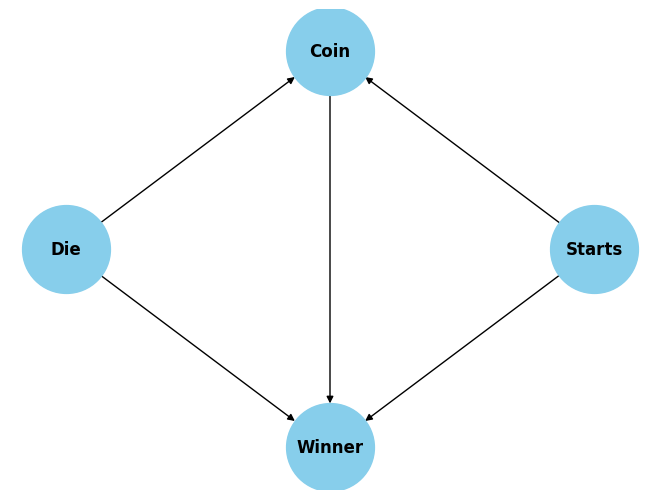

(Die ⟂ Starts)
(Starts ⟂ Die)

In [86]:

model.add_cpds(cpd_starts, cpd_die, cpd_coin, cpd_winner)
model.check_model()

pos = nx.circular_layout(model)
nx.draw(model, pos=pos, with_labels=True, node_size=4000, font_weight='bold', node_color='skyblue')
plt.show()

model.local_independencies(['Die', 'Starts', 'Coin', 'Winner'])

In [90]:
#Ex3 b)
from pgmpy.inference import VariableElimination

infer = VariableElimination(model)
posterior_p = infer.query(["Winner"])
print(f"Winner={posterior_p}")

Winner=+-----------+---------------+
| Winner    |   phi(Winner) |
+===========+===============+
| Winner(0) |        0.5733 |
+-----------+---------------+
| Winner(1) |        0.4267 |
+-----------+---------------+


In [96]:
#Ex3 c)
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)
posterior_p = infer.query(["Starts"], evidence={"Coin": 1})
print(f"Started given Coin = 1 => {posterior_p}")

Started given Coin = 1 => +-----------+---------------+
| Starts    |   phi(Starts) |
+===========+===============+
| Starts(0) |        0.5471 |
+-----------+---------------+
| Starts(1) |        0.4529 |
+-----------+---------------+
